## Load libararies and datasets

In [1]:
#import libraries
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline
import xlwings as xw
from pandas.api.types import is_numeric_dtype
import seaborn as sns

In [3]:
#load worksheets
Input = xw.Book('input.xlsx').sheets['Input']
settings = xw.Book('input.xlsx').sheets['Settings']
asset = xw.Book('input.xlsx').sheets['Asset']
data = xw.Book('input.xlsx').sheets['Back-end']
zip_nuts = pd.read_excel(pd.ExcelFile('input.xlsx'), 'Back-end2')
zip_nuts.set_index('ZIP Code to NUTS mapping', inplace = True)
nuts_id = pd.read_excel(pd.ExcelFile('input.xlsx'), 'Back-end4')
nuts_id.set_index('NUTS_ID', inplace = True)
energy_price = xw.Book('input.xlsx').sheets['Energy Price']

In [336]:
years = list(range(2018,2051))

#import raw data 
Target = pd.read_excel(pd.ExcelFile('input.xlsx'), 'GHG Target') #GHG decarbonisation target (kgco2/m2)
Target.set_index('ta', inplace = True)

Target_energy = pd.read_excel(pd.ExcelFile('input.xlsx'), 'Energy Target') #Energy consumption target (kwh/m2)
Target_energy.set_index('ta', inplace = True)

emission_factor = pd.DataFrame(data.range('A32:AK60').value) #Emissions factor: electricity & heat (trade adjusted) - A23
emission_factor.columns = emission_factor.iloc[0]
emission_factor = emission_factor[1:]
emission_factor.set_index('Country', inplace = True)

#energy costs
elec_cost = pd.DataFrame(energy_price.range('A34:AH61').value) #electricity price incl. VAT
elec_cost.set_index(0, inplace = True)
elec_cost.columns = years

gas_cost = pd.DataFrame(energy_price.range('A97:AH124').value) #gas price incl. VAT
gas_cost.set_index(0, inplace = True)
gas_cost.columns = years

oil_cost = pd.DataFrame(energy_price.range('A159:AH186').value) #oil price incl. VAT
oil_cost.set_index(0, inplace = True)
oil_cost.columns = years

wood_cost = pd.DataFrame(energy_price.range('A284:AH311').value) #wood pellets price incl. VAT
wood_cost.set_index(0, inplace = True)
wood_cost.columns = years

coal_cost = pd.DataFrame(energy_price.range('A408:AH435').value) #coal price incl. VAT
coal_cost.set_index(0, inplace = True)
coal_cost.columns = years

carbon_cost = pd.DataFrame(energy_price.range('A440:AH467').value) #carbon price incl. VAT
carbon_cost.set_index(0, inplace = True)
carbon_cost.columns = years

X2 = pd.DataFrame(data.range('X2:Y12').value) #BPN: property factor
X2.set_index(0, inplace = True)
X2.fillna(0, inplace = True)

Z4 = data.range('Z4').value

Z6 = data.range('Z6').value

AB3 = data.range('AB3').value #Margianl abatement cost

AB4 = data.range('AB4').value #Margianl abatement cost

AF2 = pd.DataFrame(data.range('AF2:AG29').value)
AF2.set_index(0, inplace = True)

In [97]:
#import EPC data
epc = pd.read_csv('domestic-E06000001-Hartlepool-certificates.csv')
epc_test = epc.head(100)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Preprocessing and EDA

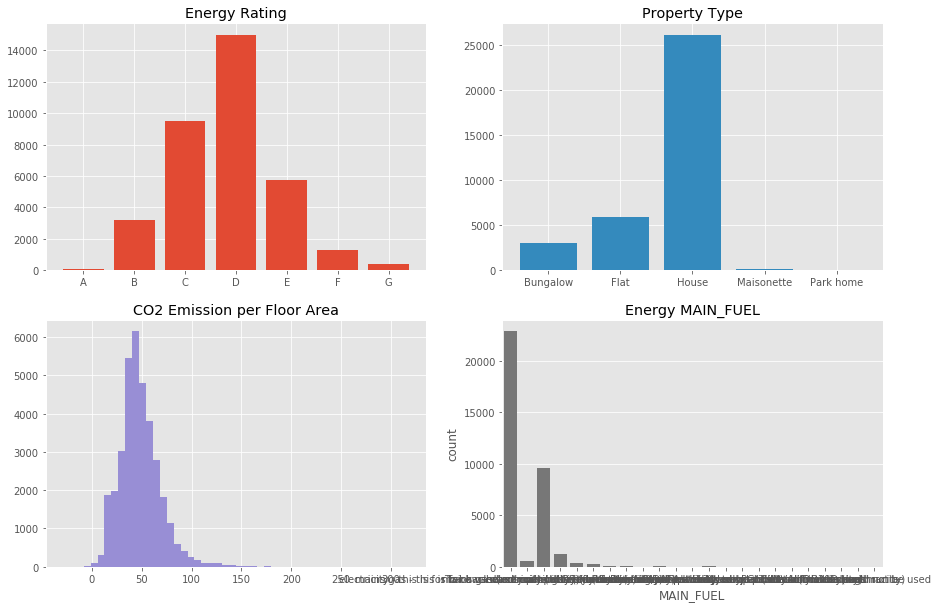

In [5]:
f, ax = plt.subplots(2,2,figsize=(15,10))
ax[0,0].bar(epc.groupby('CURRENT_ENERGY_RATING').size().index,epc.groupby('CURRENT_ENERGY_RATING').size())
ax[0,0].set_title('Energy Rating')
ax[0,1].bar(epc.groupby('PROPERTY_TYPE').size().index,epc.groupby('PROPERTY_TYPE').size(), color = 'C1')
ax[0,1].set_title('Property Type')
ax[1,0].hist(epc[epc['CO2_EMISS_CURR_PER_FLOOR_AREA']<1000]['CO2_EMISS_CURR_PER_FLOOR_AREA'], bins = 50, color = 'C2')
ax[1,0].set_title('CO2 Emission per Floor Area')
sns.countplot(epc['MAIN_FUEL'],color = 'C3',ax = ax[1,1])
ax[1,1].set_title('Energy MAIN_FUEL')
plt.show()

In [15]:
epc.groupby('MAIN_FUEL').size()

MAIN_FUEL
B30D (community)                                                                     1
Electricity: electricity, unspecified tariff                                       115
INVALID!                                                                             3
LPG (not community)                                                                 35
LPG - this is for backwards compatibility only and should not be used               10
NO DATA!                                                                           111
To be used only when there is no heating/hot-water system                          240
anthracite                                                                           1
biomass (community)                                                                  2
bottled LPG                                                                          2
bulk wood pellets                                                                    6
dual fuel - mineral + wood       

## 1. Stranding Diagram for 

Due to the lack of granularity of EPC data, assumptions are made for plotting the stranding diagram:

Emission pathway: still takes electricity grid and climate change into account.
Main fuel: 
1. Assume if electricity is main fuel, it takes 70% of emissions.
2. No distric heating/cooling and fugitive emissions.

Target pathway
Building type: 
1. All domestic buildings(Bungalow, Flat, House) are residential, target is the same for them.
2. Target positively relates to current energy intensity.
3. Constant relative differences of energy target between residential and office building for 2018-2050.

### a. Preprocessing data

In [98]:
#assumption 1 with main fuel:
#make assumptions for electricity share: 70% for main fuel
epc_test['electricity share'] = np.nan
for i in range(len(epc_test)):
    if 'electricity' in epc_test['MAIN_FUEL'][i]:
        epc_test['electricity share'][i] = 0.7
    else:
        epc_test['electricity share'][i] = 0.3

#assumption 2 with buidling type
epc_test['property type code'] = np.nan
for i in range(len(epc_test)):
    if epc_test['PROPERTY_TYPE'][i] == 'Bungalow' or 'Flat' or 'House' or 'Mansionette' or 'Park home':
        epc_test['property type code'][i] = 'RES'

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(cod

In [ ]:
#emission data
current_emission = epc_test['CO2_EMISS_CURR_PER_FLOOR_AREA']
elec_heat = 0.103 #share of electricity for heating in UK
elec_cool = 0.129
non_elec_heat = 0.779
grid_uk = emission_factor.loc['UK'][3:] #emission factor for UK

#decarbonisation pathway: residential buildings, check CRREM documentation for calculation
#assumption: 1. constant relative differences between each subsector
target_uk = pd.DataFrame()
for i in range(len(Target)):
    if 'UK' in Target.index[i]:
        target_uk = pd.concat([target_uk,pd.DataFrame(Target.loc[Target.index[i]]).T])
        
target_uk.loc['UK_RES_1.5'] = target_uk.loc['UK_OFF_1.5']*136/154
target_uk.loc['UK_RES_2'] = target_uk.loc['UK_OFF_2']*136/154

#HDD - HDD index
RCP = 'RCP4.5'
epc_test['NUTS3'] = np.nan

for i in range(len(epc_test)):
    if epc_test['POSTCODE'][i] != 0:
        epc_test['NUTS3'][i] = 'UK' + epc_test['POSTCODE'][i].split(' ')[0]
        
years = list(range(3,36))
HDD = pd.DataFrame(columns = years, index=list(range(len(epc_test))))
epc_test['POSTCODE'].fillna(0,inplace = True)
for i in range(len(epc_test)):
    for year in years:
        if RCP == 'RCP4.5':
            if epc_test['POSTCODE'][i] != 0:
                HDD.iloc[i,year-3] = (nuts_id.loc[zip_nuts.loc[epc_test['NUTS3'][i]][0]]['HDD_2015'] + year*nuts_id.loc[zip_nuts.loc[epc_test['NUTS3'][i]][0]]['HDD_45_pa'])/(nuts_id.loc[zip_nuts.loc[epc_test['NUTS3'][i]][0]]['HDD_2015'] + 3*nuts_id.loc[zip_nuts.loc[epc_test['NUTS3'][i]][0]]['HDD_45_pa'])
            else:
                HDD.iloc[i,year-3] = (nuts_id.loc['UK']['HDD_2015'] + year*nuts_id.loc['UK']['HDD_45_pa'])/(nuts_id.loc['UK']['HDD_2015'] + 3*nuts_id.loc['UK']['HDD_45_pa'])
        else:
            if epc_test['POSTCODE'][i] != 0:
                HDD.iloc[i,year-3] = (nuts_id.loc[zip_nuts.loc[epc_test['NUTS3'][i]][0]]['HDD_2015'] + year*nuts_id.loc[zip_nuts.loc[epc_test['NUTS3'][i]][0]]['HDD_85_pa'])/(nuts_id.loc[zip_nuts.loc[epc_test['NUTS3'][i]][0]]['HDD_2015'] + 3*nuts_id.loc[zip_nuts.loc[epc_test['NUTS3'][i]][0]]['HDD_85_pa'])
            else:
                HDD.iloc[i,year-3] = (nuts_id.loc['UK']['HDD_2015'] + year*nuts_id.loc['UK']['HDD_85_pa'])/(nuts_id.loc['UK']['HDD_2015'] + 3*nuts_id.loc['UK']['HDD_85_pa'])
#CDD - CDD index
years = list(range(3,36))
CDD = pd.DataFrame(columns = years, index=list(range(len(epc_test))))
for i in range(len(epc_test)):
    for year in years:
        if RCP == 'RCP4.5':
            if epc_test['POSTCODE'][i] != 0:
                CDD.iloc[i,year-3] = (nuts_id.loc[zip_nuts.loc[epc_test['NUTS3'][i]][0]]['CDD_2015'] + year*nuts_id.loc[zip_nuts.loc[epc_test['NUTS3'][i]][0]]['CDD_45_pa'])/(nuts_id.loc[zip_nuts.loc[epc_test['NUTS3'][i]][0]]['CDD_2015'] + 3*nuts_id.loc[zip_nuts.loc[epc_test['NUTS3'][i]][0]]['CDD_45_pa'])
            else:
                CDD.iloc[i,year-3] = (nuts_id.loc['UK']['CDD_2015'] + year*nuts_id.loc['UK']['CDD_45_pa'])/(nuts_id.loc['UK']['CDD_2015'] + 3*nuts_id.loc['UK']['CDD_45_pa'])
        else:
            if epc_test['POSTCODE'][i] != 0:
                CDD.iloc[i,year-3] = (nuts_id.loc[zip_nuts.loc[epc_test['NUTS3'][i]][0]]['CDD_2015'] + year*nuts_id.loc[zip_nuts.loc[epc_test['NUTS3'][i]][0]]['CDD_85_pa'])/(nuts_id.loc[zip_nuts.loc[epc_test['NUTS3'][i]][0]]['CDD_2015'] + 3*nuts_id.loc[zip_nuts.loc[epc_test['NUTS3'][i]][0]]['CDD_85_pa'])
            else:
                CDD.iloc[i,year-3] = (nuts_id.loc['UK']['CDD_2015'] + year*nuts_id.loc['UK']['CDD_85_pa'])/(nuts_id.loc['UK']['CDD_2015'] + 3*nuts_id.loc['UK']['CDD_85_pa'])
CDD.columns = list(range(2018,2051))
HDD.columns = list(range(2018,2051))

In [26]:
#GHG emission projection
years = list(range(2018,2051))
emission = pd.DataFrame(columns = years, index=list(range(len(epc_test))))

#district heating/cooling and fugitive emission not considered
for i in range(len(epc_test)):
    for year in years:
        emission.iloc[i,year-2018] = current_emission[i]*(epc_test['electricity share'][i]*grid_uk[year]/grid_uk[2018]*(1+elec_heat*(HDD.iloc[i][year]-1)+elec_cool*(CDD.iloc[i][year]-1))
        + ((1-epc_test['electricity share'][i])*HDD.iloc[i][year]/HDD.iloc[i][2018]*(1+non_elec_heat*(HDD.iloc[i][year]-1))))

### b.define function

In [88]:
def stranding_diagram_epc(asset_num, target_temp):
    years = list(range(2018,2051))
    
    asset_code = 'UK' + '_' + epc_test['property type code'][asset_num-1] + '_' + str(target_temp)
    target = target_uk.loc[asset_code]
    
    Climate_grid = emission
    climate_grid = Climate_grid.iloc[asset_num-1,:]
    Baseline = [climate_grid.iloc[0]]*len(climate_grid) #create baseline pandas series with same index as climate_grid
    baseline = pd.Series(Baseline, index = climate_grid.index)   

    #plot diagram
    plt.figure(figsize = (20,10))
    plt.plot(target, 'g', label = 'Decarbonisation target')
    plt.plot(climate_grid, 'k', label = 'Climate and grid corrected asset performance')
    plt.plot(baseline, ':k', label = 'Baseline asset performance')
    plt.plot(baseline.iloc[[0]],'kD', markersize = 10, label = '2018 performance') 
    
    #highlight stranding year
    stranding = target - climate_grid
    if (stranding<0).any():
        stranding_year = stranding[stranding < 0].index[0]
        plt.plot(climate_grid[[stranding_year]], 'ro', markersize = 20, label = 'Stranding')
    
    #Excess emissions
    plt.fill_between(years, target.tolist(), climate_grid.tolist(), where = (target < climate_grid), color='C1', alpha=0.3, label = 'Excess emissions')
    plt.legend(loc = 'best', fontsize = 12)

    #set title and axis labels
    asset_name = epc['POSTCODE'].iloc[asset_num-1]
    plt.title(f'Stranding Diagram(Asset #{asset_num} - {asset_name})', fontsize = 25)
    plt.xlabel('Year', fontsize = 15)
    plt.ylabel('GHG intensity [kgCO2e/m²/a]', fontsize = 15)
    plt.show()

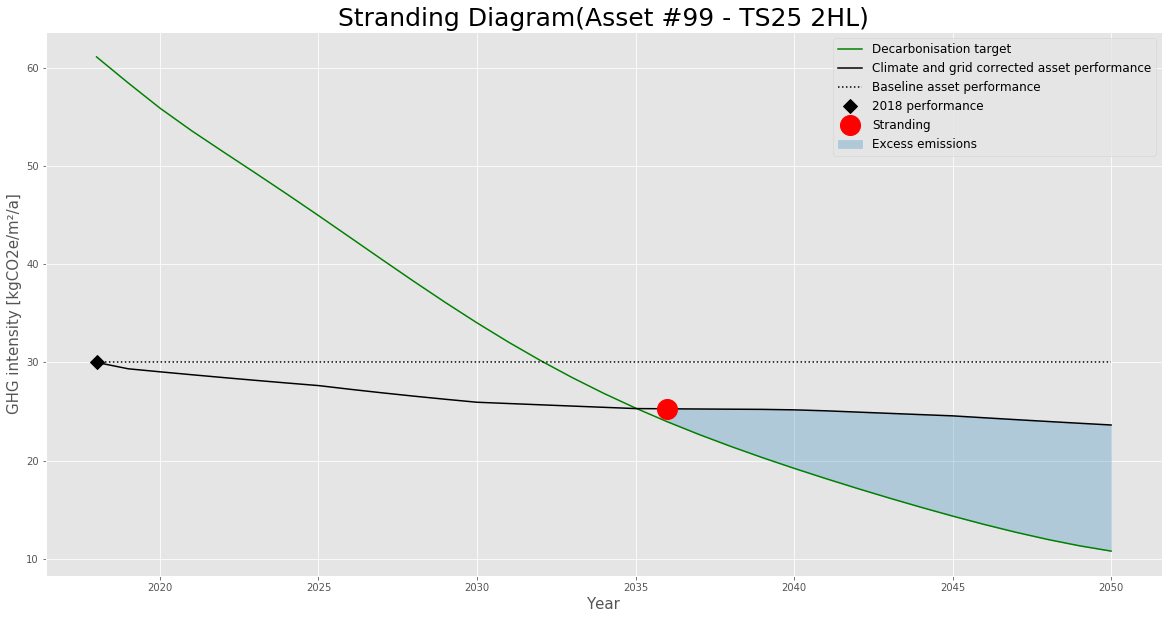

In [89]:
stranding_diagram_epc(99, 2)

### c. further exploration

In [21]:
#relationship between stranding year and energy ratings
target_temp = 1.5
stranding_year = pd.DataFrame(epc_test['CURRENT_ENERGY_RATING'])
stranding_year['stranding year'] = np.nan
for i in range(len(epc_test)):
    asset_code = 'UK' + '_' + 'RES' + '_' + str(target_temp)
    target = target_uk.loc[asset_code]
    stranding = target-emission.iloc[i,:]
    if (stranding<0).any():
        stranding_year['stranding year'][i] = stranding[stranding < 0].index[0]
    else:
        stranding_year['stranding year'][i] = 2050
        
stranding_year.groupby(['CURRENT_ENERGY_RATING']).mean()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,stranding year
CURRENT_ENERGY_RATING,
B,2037.000000
C,2025.000000
D,2021.000000
E,2019.666667
F,2018.000000


## Formulas from CRREM

In [ ]:
#KP
$KK4*($KB4*(((EE4/INDEX($EB4:$FK4,4))*Input!$AF14/$CZZ4+(1-Input!$AF14/$CZZ4))*
(1+VLOOKUP($AR4,$BMG$2:$BMI$30,2,FALSE) *(BI4-1)+IF(Input!$AB14="No",0,VLOOKUP($AR4,$BMG$2:$BMI$30,3,FALSE))*(CT4-1)))
+($KC4+$KD4+$KG4)*(BI4/INDEX($BF4:$CO4,4))*(1+VLOOKUP($AR4,$BMG$2:$BMJ$30,4,FALSE)*(BI4-1))
+$KF4*(CT4/INDEX($CQ4:$DZ4,4))+$KE4*BI4+$KH4)

GHG absolute (account for HDD/CDD and grid) = 

#main
baseline emission with normalisation

#1. scaling factor by electricity grid: grid (A24: declines over time as electricity grid becomes more efficient)
#2. scaling factor by HDD/CDD: heat/cool degree days(The variables are calculated by comparing the temperatures of a certain day with a specific base temperature, 
#below (HDD) or above (CDD) which the building will need to be heated or cooled. Finally, these daily differences are summed up over the whole year.)
#HDD rises and CDD declines over time due to climate change effect on energy usage
*(electricity emission share*(((grid/grid_2018)*electricity usage/electricity procurement 2018+1-electricity usage/electricity procurement 2018)*
                              (1 + electricity share for heating * (HDD-1) + electricity share for cooling * (CDD-1)))

#assumption: gas not used for cooling?
+ (gas emission share + oil share + other share) * (HDD/HDD_2018) * (1 + fossil fuel share for heating * (HDD-1))

+ dist.heat share * HDD

+ dist.cool share * CDD/CDD_2018

+ fugitive share
)


# KK
-KA3+
(KJ3+KA3)*
(AWY3*KB3*(1+(VLOOKUP($AR3,$BMG$2:$BMI$30,2,FALSE)*(BI3*$AWZ3-1))+(VLOOKUP($AR3,$BMG$2:$BMI$30,3,FALSE)*(CT3*$AXA3-1)))+
(KC3+KD3+KE3)* (1+VLOOKUP($AR3,$BMG$2:$BMJ$30,4,FALSE)*(BI3*$AWZ3-1))*AWZ3+KF3*AXA3)

baseline emission with normalisation(occupancy and weather) = 

#export emission is deducted from total emission (why no need to scale here?)
-export emission+

#main
(total emission + export emission)

#scaling factor by 1. occupancy(but only for electricity) and heat/cool usage 2. HDD further accounts for weather variation
#assumption is that only electricity scales up with occupancy rate

*(electricity emission share*occupancy normalisation*
(1 + electricity share for heating*(HDD*weather normalisation heat-1) + electricity share for cooling*(CDD*weather normalisation cool-1))

+ (gas emission share + oil share + dist.heat share)*(1+fossil fuel share for heating*(HDD*weather normalisation heat-1))*weather normalisation heat

+ dist.cool share * weather normalisation cool

)                            

#KJ 
=JT3*CUS3+
(JU3+JV3+JW3+JY3)*CUO3+
JX3*CUQ3+
JZ3*AWX3
+AWX3*KA3

#scaled by missing monthly data, scale depending on share of heating/electricity per month (unsure how this share is calculated)

total emission = 

electricity emission*Electro.norm.12M

+ (gas emission + oil emission + dist.heat emission + other emission)*Heat.norm.12M

+ dist.cool emission*Cool.norm.12M

+ fugitive emission*Reporting length normalisation

+ export emission*Reporting length normalisation


#JT-KA: all types of emissions 

#scaled by missing data (maximum coverage/data coverage)

= scale factor * (energy use - renewable use) * unit conversion to kgco2e


For example:
    
JT: electricity emission
=IF(Input!$D13="Exclude","",
AWQ3*((Input!AF13-Input!BM13)*IF(
Settings!G13="Default", VLOOKUP('Back-end'!AR3,'Back-end'!A$23:AK$51,5,FALSE),
IF(Settings!H13="Set 2018 value and annual rate of change",Settings!I13,Settings!BI13))
+(Input!BM13*IF(Input!BN13="Location-based approach",IF(Settings!G13="Default",VLOOKUP('Back-end'!AR3,'Back-end'!A$23:AK$51,Input!F13-2013,FALSE),
IF(Settings!H13="Set 2018 value and annual rate of change",Settings!I13,Settings!BI13)),Input!BO13))))

electricity scale factor*(energy use - renewable use)*emissions factor + renewable use*(emissions factor or market based factor)


## 2. Energy Reduction Pathway

assumption: 
1. Same calculation as energy emission because energy emission = emission factor * energy consumption

In [36]:
#load energy target
energy_target_uk = pd.DataFrame()
for i in range(len(Target_energy)):
    if 'UK' in Target.index[i]:
        energy_target_uk = pd.concat([energy_target_uk,pd.DataFrame(Target_energy.loc[Target_energy.index[i]]).T])
        
energy_target_uk.loc['UK_RES_1.5'] = energy_target_uk.loc['UK_OFF_1.5']*136/154
energy_target_uk.loc['UK_RES_2'] = energy_target_uk.loc['UK_OFF_2']*136/154

#energy energy projection
current_energy = epc_test['ENERGY_CONSUMPTION_CURRENT']
years = list(range(2018,2051))
energy = pd.DataFrame(columns = years, index=list(range(len(epc_test))))
for i in range(len(epc_test))a
    for year in years:
        energy.iloc[i,year-2018] = current_energy[i]*(epc_test['electricity share'][i]*grid_uk[year]/grid_uk[2018]*(1+elec_heat*(HDD.iloc[i][year]-1)+elec_cool*(CDD.iloc[i][year]-1))
        + ((1-epc_test['electricity share'][i])*HDD.iloc[i][year]/HDD.iloc[i][2018]*(1+non_elec_heat*(HDD.iloc[i][year]-1))))

In [86]:
def energy_reduction_pathway(asset_num, target_temp):

    asset_code = 'UK' + '_' + epc_test['property type code'][asset_num-1] + '_' + str(target_temp)
    target = energy_target_uk.loc[asset_code]
    
    energy_intensity = energy.iloc[asset_num-1,:]
    
    #plot diagram
    plt.figure(figsize = (20,10))
    plt.plot(target, 'g', label = 'Country & property type specific target')
    plt.plot(energy_intensity, 'k', label = 'Asset energy intensity')
    plt.legend(fontsize = 12)

    asset_name = epc['POSTCODE'].iloc[asset_num-1]
    plt.title(f'Energy Reduction Pathway(Asset #{asset_num} - {asset_name})', fontsize = 25)
    plt.xlabel('Year', fontsize = 15)
    plt.ylabel('Energy intensity [kWh/m²/yr]', fontsize = 15)
    plt.show()

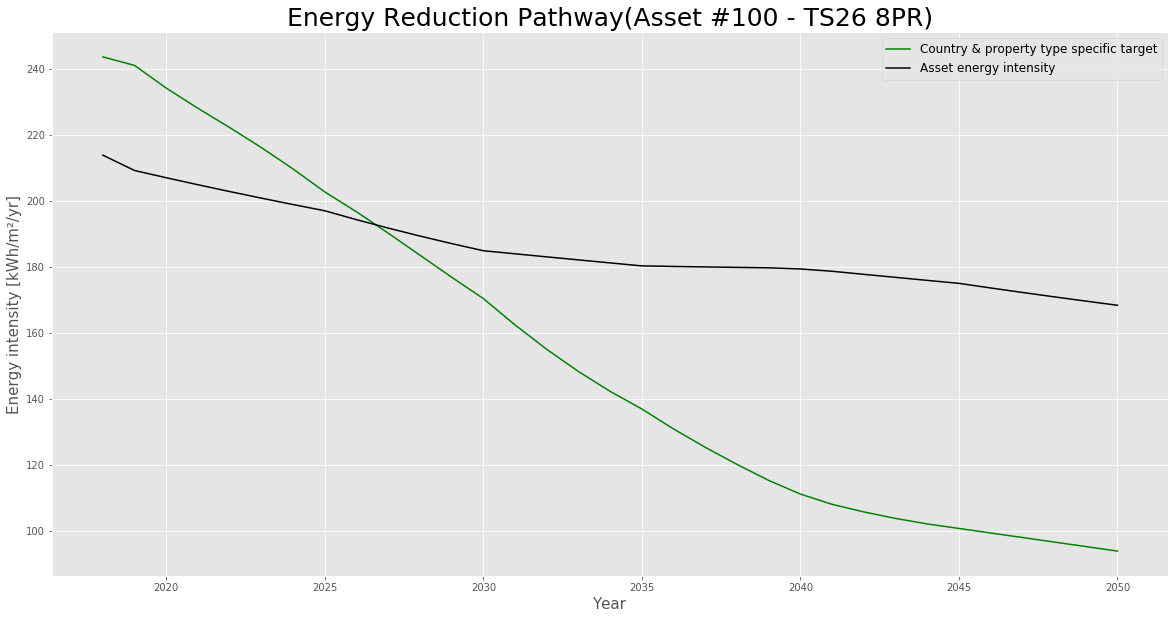

In [87]:
energy_reduction_pathway(100, 2)

## 3. Excess Emissions per Floor Area

In [84]:
def excess_emissions_per_floor_area(asset_num):
    
    #excess emission = emission - target 
    asset_code1 = 'UK' + '_' + epc_test['property type code'][asset_num-1] + '_' + '1.5'
    asset_code2 = 'UK' + '_' + epc_test['property type code'][asset_num-1] + '_' + '2'
    target1 = target_uk.loc[asset_code1]
    target2 = target_uk.loc[asset_code2]
    Climate_grid = emission
    climate_grid = Climate_grid.iloc[asset_num-1,:]
    stranding1 = climate_grid - target1
    stranding2 = climate_grid - target2
    
    #plot diagram
    plt.figure(figsize = (20,10))
    plt.plot(stranding1, 'blue', label = '1.5°C-target')
    plt.plot(stranding2, 'green', label = '2°C-target')
    plt.legend(fontsize = 12)
    
    #set title and axis labels
    asset_name = epc['POSTCODE'].iloc[asset_num-1]
    plt.title(f'EXCESS EMISSIONS PER FLOOR AREA(Asset #{asset_num} - {asset_name})', fontsize = 25)
    plt.xlabel('Year', fontsize = 15)
    plt.ylabel('Excess emissions per floor area [kgCO2e/m²/yr]', fontsize = 15)
    plt.show()

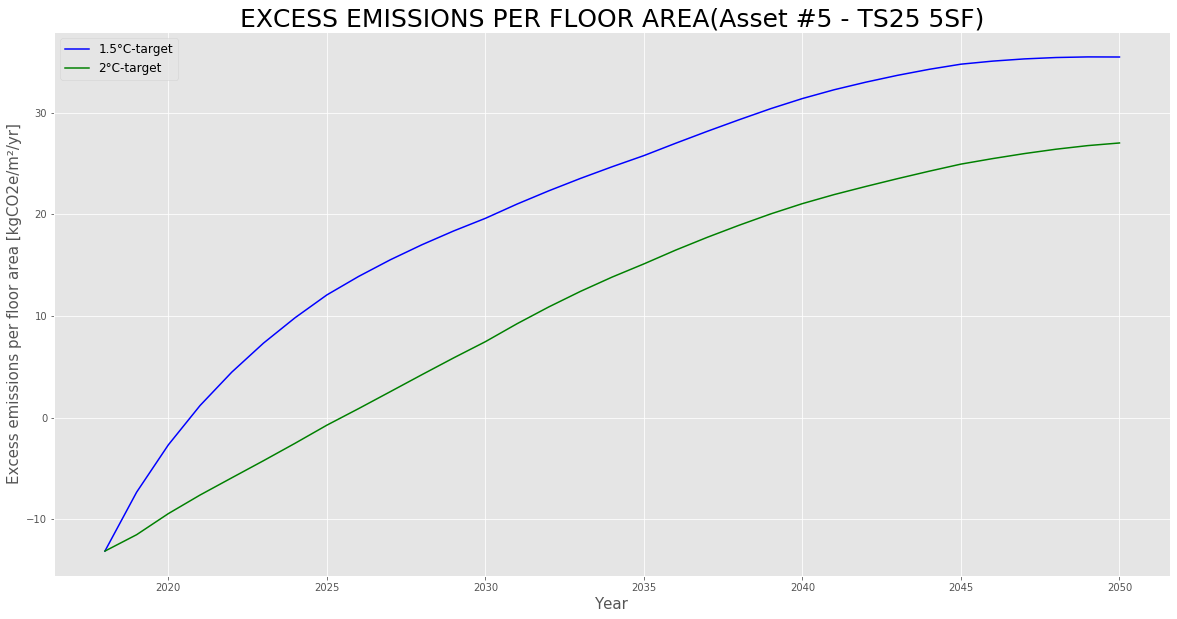

In [93]:
excess_emissions_per_floor_area(5)

## 4.  Costs of Energy & Carbon Emissions

In [118]:
def cost_of_energy_and_carbon_emissions(asset_num): 
    
    #assumption: main fuel takes 70% of emissions
    if 'electricity' in epc['MAIN_FUEL'][asset_num-1]:
        elec_cost = total_energy[asset_num-1]*elec_cost.loc['UK']*0.7
        gas_cost = total_energy[asset_num-1]*gas_cost.loc['UK']*0.3
        oil_cost = total_energy[asset_num-1]*oil_cost.loc['UK']*0
        coal_cost = total_energy[asset_num-1]*coal_cost.loc['UK']*0
        wood_cost = total_energy[asset_num-1]*wood_cost.loc['UK']*0
    elif 'gas' in epc['MAIN_FUEL'][asset_num-1]:
        elec_cost = total_energy[asset_num-1]*elec_cost.loc['UK']*0.3
        gas_cost = total_energy[asset_num-1]*gas_cost.loc['UK']*0.7
        oil_cost = total_energy[asset_num-1]*oil_cost.loc['UK']*0
        coal_cost = total_energy[asset_num-1]*coal_cost.loc['UK']*0
        wood_cost = total_energy[asset_num-1]*wood_cost.loc['UK']*0
    elif 'oil' in epc['MAIN_FUEL'][asset_num-1]:
        elec_cost = total_energy[asset_num-1]*elec_cost.loc['UK']*0.5
        gas_cost = total_energy[asset_num-1]*gas_cost.loc['UK']*0.5
        oil_cost = total_energy[asset_num-1]*oil_cost.loc['UK']*0.7
        coal_cost = total_energy[asset_num-1]*coal_cost.loc['UK']*0
        wood_cost = total_energy[asset_num-1]*wood_cost.loc['UK']*0
    elif 'coal' in epc['MAIN_FUEL'][asset_num-1]:
        elec_cost = total_energy[asset_num-1]*elec_cost.loc['UK']*0.15
        gas_cost = total_energy[asset_num-1]*gas_cost.loc['UK']*0.15 
        oil_cost = total_energy[asset_num-1]*oil_cost.loc['UK']*0
        coal_cost = total_energy[asset_num-1]*coal_cost.loc['UK']*0.7
        wood_cost = total_energy[asset_num-1]*wood_cost.loc['UK']*0
    elif 'wood' in epc['MAIN_FUEL'][asset_num-1]:
        elec_cost = total_energy[asset_num-1]*elec_cost.loc['UK']*0.15
        gas_cost = total_energy[asset_num-1]*gas_cost.loc['UK']*0.15
        oil_cost = total_energy[asset_num-1]*oil_cost.loc['UK']*0
        coal_cost = total_energy[asset_num-1]*coal_cost.loc['UK']*0
        wood_cost = total_energy[asset_num-1]*wood_cost.loc['UK']*0.7
    else:
        elec_cost = total_energy[asset_num-1]*elec_cost.loc['UK']*0.5
        gas_cost = total_energy[asset_num-1]*gas_cost.loc['UK']*0.5
        oil_cost = total_energy[asset_num-1]*oil_cost.loc['UK']*0
        coal_cost = total_energy[asset_num-1]*coal_cost.loc['UK']*0
        wood_cost = total_energy[asset_num-1]*wood_cost.loc['UK']*0
    
    #plot stackplot for energy costs
    plt.figure(figsize = (20,10))
    plt.stackplot(years, elec_cost, gas_cost, oil_cost, coal_cost, wood_cost, labels = ['Electricity','Gas', 'Oil', 'Coal', 'Wood'], colors = ['pink','lightblue','grey','lightgreen','orange'])
    plt.legend(loc = 'upper left', fontsize = 12)
    asset_name = epc['POSTCODE'].iloc[asset_num-1]
    plt.title(f'COSTS OF ENERGY & CARBON EMISSIONS(Asset #{asset_num} - {asset_name})', fontsize = 25)
    plt.xlabel('Year', fontsize = 15)
    plt.ylabel('Annual energy costs [€/yr]', fontsize = 15)
    plt.show()

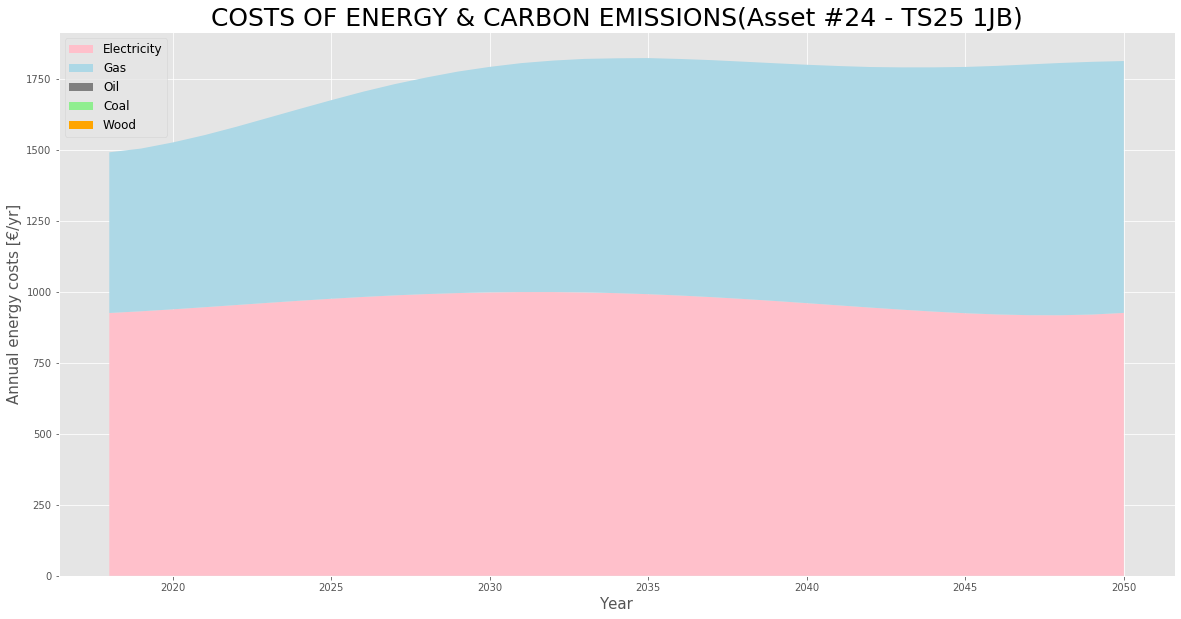

In [129]:
cost_of_energy_and_carbon_emissions(24)

## 5. Total Net Energy per Floor Area

In [230]:
floor_area = epc_test['TOTAL_FLOOR_AREA']

In [231]:
def carbon_cost_of_excess_emissions(asset_num, target_temp):
    
    carbon_price = carbon_cost.loc['UK']
    total_emission = emission.iloc[asset_num-1] * floor_area.iloc[asset_num-1]

    asset_code = 'UK' + '_' + epc_test['property type code'][asset_num-1] + '_' + str(target_temp)
    total_target = target_uk.loc[asset_code]* floor_area.iloc[asset_num-1]
    
    excess_cost = carbon_price*(total_emission-total_target)
    
    
    years = list(range(2018,2051))
    costs = pd.Series(np.nan, index = years)
    value = pd.Series(np.nan, index = years)
    for year in years:
        if excess_cost[year]<0:
            costs[year] = 0
            value[year] = excess_cost[year]
        else:
            costs[year] = excess_cost[year]
            value[year] = 0

    #plot diagram
    plt.figure(figsize = (20,10))
    plt.plot(costs, 'k')
    Baseline = [0]*len(costs)
    baseline = pd.Series(Baseline, index = costs.index) 
    plt.fill_between(years, value.to_list(), 0, where = (costs == 0), color='green', alpha=0.3, label = 'Value')
    plt.fill_between(years, costs.to_list(), 0, where = (costs > value), color='C0', alpha=0.3, label = 'Costs')
    plt.legend(fontsize = 12)

    asset_name = epc['POSTCODE'].iloc[asset_num-1]
    plt.title(f'CARBON COSTS OF EXCESS EMISSIONS(Asset #{asset_num} - {asset_name})', fontsize = 25)
    plt.xlabel('Year', fontsize = 15)
    plt.ylabel('Annual Cost [€/yr]', fontsize = 15)
    plt.show()

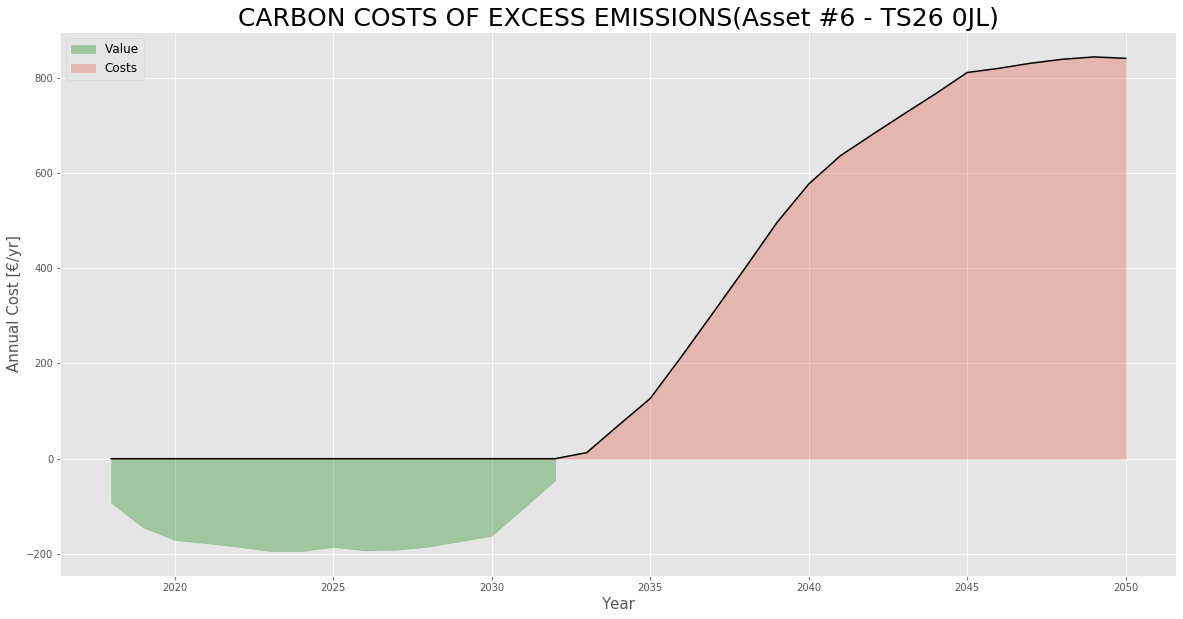

In [232]:
carbon_cost_of_excess_emissions(6, 2)

## 6. Cost of retrofitting to comply with decarbonisation pathway:

assumptions:
1. AC PT FACTOR (X2) for residential property is 1



In [456]:
def retrofit_costs(asset_num):
    
    asset_code1 = 'UK' + '_' + epc_test['property type code'][asset_num-1] + '_' + '1.5'
    asset_code2 = 'UK' + '_' + epc_test['property type code'][asset_num-1] + '_' + '2'
    target1 = target_uk.loc[asset_code1]
    target2 = target_uk.loc[asset_code2]
    
    #BWK: marginal abatement cost
    BWK3 = AB3
    BWK4 = AB4
    #BPK: Country/AC.CY.Factor
    BPK = AF2
    
    Costs1 = pd.DataFrame(columns = years, index=list(range(len(epc_test))))
    Costs2 = pd.DataFrame(columns = years, index=list(range(len(epc_test))))
    for i in range(len(epc_test)):
        for year in years:
            if emission.iloc[asset_num-1][year] > target1[year]:
                Costs1.iloc[i,year-2018] = floor_area.iloc[asset_num-1]*BWK3/BWK4*X2.loc[epc_test['property type code'][asset_num-1]][1]*(AF2.loc['UK'].iloc[0])*(math.exp(BWK4*energy.iloc[asset_num-1][year]/floor_area.iloc[asset_num-1])-math.exp(BWK4*target1[year]*floor_area.iloc[asset_num-1]/(emission.iloc[asset_num-1][year]*floor_area.iloc[asset_num-1])*energy.iloc[asset_num-1][year]/floor_area.iloc[asset_num-1]))*(1-(Z4*(1-target1[year]*floor_area.iloc[asset_num-1]/(emission.iloc[asset_num-1][year]*floor_area.iloc[asset_num-1]))**2+Z6*(1-target1[year] *floor_area.iloc[asset_num-1]/(emission.iloc[asset_num-1][year]*floor_area.iloc[asset_num-1])+Z6)))**(year-2015)
                
            else:
                Costs1.iloc[i,year-2018] = 0
                
            if emission.iloc[asset_num-1][year] > target2[year]:
                Costs2.iloc[i,year-2018] =  floor_area.iloc[asset_num-1]*BWK3/BWK4*X2.loc[epc_test['property type code'][asset_num-1]][1]*(AF2.loc['UK'].iloc[0])*(math.exp(BWK4*energy.iloc[asset_num-1][year]/floor_area.iloc[asset_num-1])-math.exp(BWK4*target2[year]*floor_area.iloc[asset_num-1]/(emission.iloc[asset_num-1][year]*floor_area.iloc[asset_num-1])*energy.iloc[asset_num-1][year]/floor_area.iloc[asset_num-1]))*(1-(Z4*(1-target2[year]*floor_area.iloc[asset_num-1]/(emission.iloc[asset_num-1][year]*floor_area.iloc[asset_num-1]))**2+Z6*(1-target2[year] *floor_area.iloc[asset_num-1]/(emission.iloc[asset_num-1][year]*floor_area.iloc[asset_num-1])+Z6)))**(year-2015)
                
            else:
                Costs2.iloc[i,year-2018] = 0
    
    #plot diagram
    plt.figure(figsize = (20,10))
    plt.plot(Costs1.iloc[asset_num-1], 'blue', label = '1.5°C target')
    plt.plot(Costs2.iloc[asset_num-1], 'orange', label = '2°C target')
    plt.legend(fontsize = 12)

    asset_name = epc['POSTCODE'].iloc[asset_num-1]
    plt.title(f'Costs of Retrofitting to Comply with Decarbonisation Pathway(Asset #{asset_num} - {asset_name})', fontsize = 25)
    plt.xlabel('Year', fontsize = 15)
    plt.ylabel('Retrofit Costs [€]', fontsize = 15)
    plt.show()

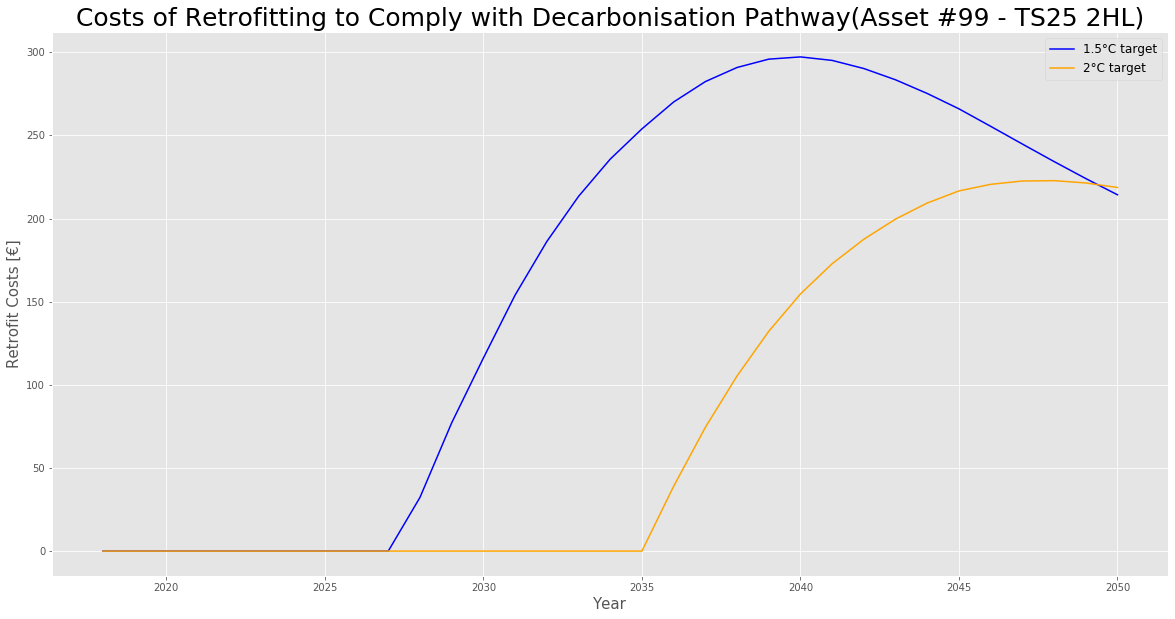

In [458]:
retrofit_costs(99)